In [1]:
import scanpy as sc
import scvelo as scv
import anndata2ri
from rpy2.rinterface_lib import callbacks
callbacks._WRITECONSOLE_EXCEPTION_LOG = "    %s"
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)
anndata2ri.activate()
%load_ext rpy2.ipython

In [2]:
import pandas as pd
adata_glia=sc.read("../SS2/data/adata_glia_focus.h5ad")
adata_glia.uns["assignments_colors"]=adata_glia.uns["milestones_colors"]
adata_glia.obs["assignments"]=adata_glia.obs.milestones
ass_cols=pd.Series(adata_glia.uns["assignments_colors"],index=adata_glia.obs.assignments.cat.categories)
adata_tree=sc.read("../SS2/data/adata_tree.h5ad")
adata_glia.obs["t"]=adata_tree[adata_glia.obs_names].obs.t
#adata_glia.obs["t"]=(adata_glia.obs["t"]>.07).astype(str)
adata_glia=adata_glia[adata_glia.obs.devtime.isin(['P0','P2', 'P6', 'P10', 'Adult'])]
adata_glia=adata_glia[adata_glia.obs.t>0.07]
adata_raw=sc.read("../SS2/data/adata_glia_raw.h5ad")
adata_raw=adata_raw[adata_glia.obs_names]
adata_raw.obs=adata_glia.obs

In [3]:
adata=sc.read("adata_combined.h5ad")

In [4]:
adata_unj=sc.AnnData(pd.read_table("GSM3408139_Uninj_Sciatic_Mesenchymal.txt.gz",index_col=0).T)
adata_inj=sc.AnnData(pd.read_table("GSM3408137_Inj_Sciatic_Beads.txt.gz",index_col=0).T)

In [5]:
import anndata
adata_sat=anndata.concat([adata_unj,adata_inj],join="outer",fill_value=0)

In [6]:
adata=sc.read("adata_combined.h5ad")
#adata_sat=sc.AnnData(pd.read_table("GSM3408139_Uninj_Sciatic_Mesenchymal.txt.gz",index_col=0).T)
adata_sat=adata_sat[adata.obs_names]
adata_sat.obsm=adata.obsm
adata_sat.obs=adata.obs

In [7]:
%%R -i adata_sat -i adata_raw
library(Seurat)
adata_sat <- as.Seurat(adata_sat,counts="X",data = "X")
adata_glia <- as.Seurat(adata_raw,counts="X",data = "X")
p2_sat=pagoda2::basicP2proc(adata_sat@assays$RNA@counts,n.cores = 20,n.odgenes = NULL,get.largevis=FALSE,get.tsne = FALSE, make.geneknn=FALSE)
p2_glia=pagoda2::basicP2proc(adata_glia@assays$RNA@counts,n.cores = 20,n.odgenes = NULL,get.largevis=FALSE,get.tsne = FALSE, make.geneknn=FALSE)

creating space of type angular done
adding data ... done
building index ... done
querying ... done
creating space of type angular done
adding data ... done
building index ... done
querying ... done


In [8]:
%%R -o graph_conn -o members -o assignments_proj -o proj_names
library(conos)
panel<-list(p2_glia,p2_sat)
names(panel)<-c("glia","sat")
con <- Conos$new(panel, n.cores=1)
con$buildGraph(k=30, k.self=15, space='PCA',ncomps=20)

graph_conn <- igraph::as_adjacency_matrix(con$graph, attr="weight")
members = colnames(graph_conn)

milestones=adata_glia@meta.data$assignments
names(milestones)=colnames(adata_glia)
assignments_proj <- con$propagateLabels(labels = milestones, verbose=FALSE)
proj_names <- names(assignments_proj$labels)

...

In [9]:
import pandas as pd
members=pd.Series(members)

glia_members=members[members.str.contains("SS2")]
sat_members=members[~members.str.contains("SS2")]
graph_conn=graph_conn[sat_members.index,:][:,glia_members.index]
glia_members.reset_index(drop=True,inplace=True)
sat_members.reset_index(drop=True,inplace=True)

In [10]:
import numpy as np
np.sum(graph_conn[0,:].A[0])

8.966182053089142

In [11]:
graph_conn[0,:].A

array([[0.72116125, 0.80033284, 0.76001734, ..., 0.        , 0.        ,
        0.        ]])

In [12]:
import numpy as np
umap=np.asarray(adata_glia[glia_members].obsm["X_umap"])
proj_umap=list(map(lambda i: [np.nansum((graph_conn[i,:].A*umap[:,0])[0]/np.sum(graph_conn[i,:].A[0])),
                              np.nansum((graph_conn[i,:].A*umap[:,1])[0]/np.sum(graph_conn[i,:].A[0]))],
                   range(graph_conn.shape[0])))

adata_sat.obsm["X_umap"]=pd.DataFrame(proj_umap,index=sat_members).loc[adata_sat.obs_names].values

In [13]:
assignments_proj=pd.Series(assignments_proj.rx("labels")[0],index=proj_names)

In [14]:
adata.obs["assignments_proj"]=assignments_proj[adata.obs_names].values

Trying to set attribute `.obs` of view, copying.
... storing 'assignments_proj' as categorical


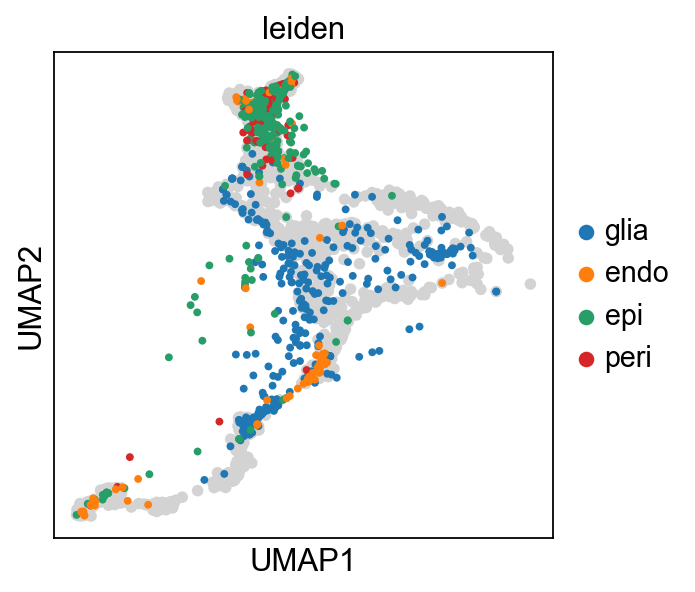

In [15]:
sc.set_figure_params()
ax=sc.pl.umap(adata_glia,show=False)
sc.pl.umap(adata_sat[adata_sat.obsm["X_umap"].sum(axis=1)!=0],s=50,color="leiden",ax=ax)

Trying to set attribute `.obs` of view, copying.
... storing 'assignments_proj' as categorical


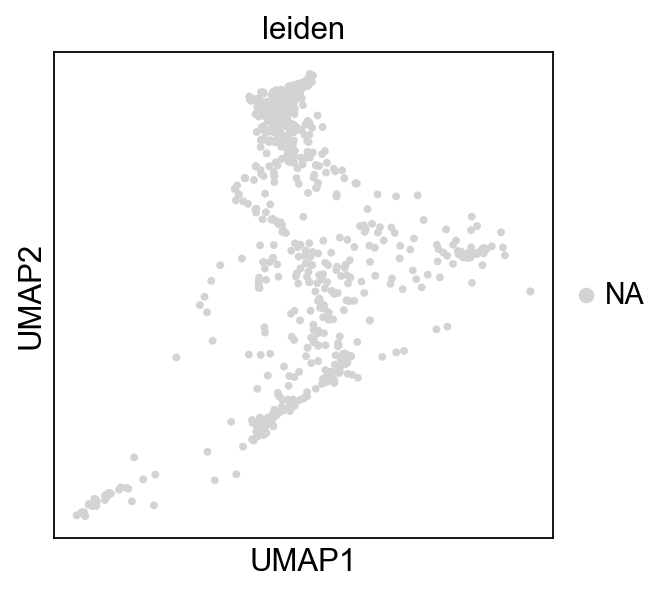

In [16]:
sc.pl.umap(adata_sat[adata_sat.obsm["X_umap"].sum(axis=1)!=0],groups=["1"],s=50,color="leiden")

In [17]:
umap=pd.DataFrame(adata_sat.obsm["X_umap"],index=adata.obs_names)

In [18]:
umap.loc[umap.sum(axis=1)!=0].to_csv("UMAP_projected.csv")

In [19]:
adata_glia.uns["assignments_colors"]=[ass_cols[c] for c in adata_glia.obs.assignments.cat.categories]

Trying to set attribute `.uns` of view, copying.


In [20]:
adata.uns["assignments_proj_colors"]=adata_glia.uns["assignments_colors"]

In [21]:
adata=adata[adata.obs.assignments_proj!="none"]

In [22]:
adata

View of AnnData object with n_obs × n_vars = 1302 × 13817
    obs: 'leiden', 'assignments_proj'
    var: 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap', 'assignments_proj_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [23]:
cells_fitted=adata_sat[adata_sat.obsm["X_umap"].sum(axis=1)!=0].obs_names

In [24]:
adata_fitted=adata[adata.obs_names.isin(cells_fitted)]

In [25]:
adata_fitted.obs.assignments_proj=adata_fitted.obs.assignments_proj.astype("category")

Trying to set attribute `.obs` of view, copying.


In [26]:
adata_fitted.uns["assignments_proj_colors"] = [ass_cols[a] for a in adata_fitted.obs.assignments_proj.cat.categories]

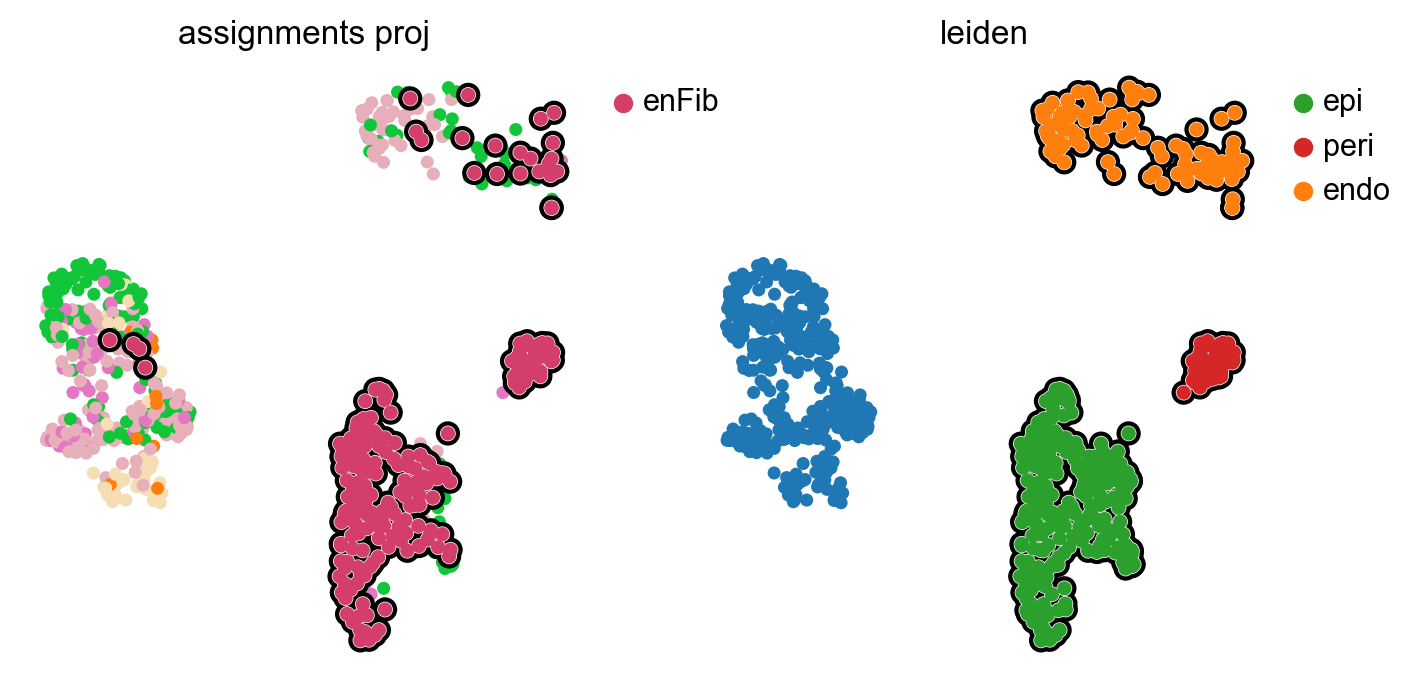

In [27]:
scv.set_figure_params(figsize=(4,4))
scv.pl.scatter(adata_fitted,color=["assignments_proj","leiden"],add_outline=["epi","peri","endo","enFib"],legend_loc="upper right")

In [28]:
leiden=adata.obs.leiden.astype(str)
props=adata_fitted.obs.leiden.value_counts(sort=False)/adata.obs.leiden.value_counts(sort=False)

In [29]:
adata.obs["props"]=leiden.replace(props.index,props.values)

Trying to set attribute `.obs` of view, copying.


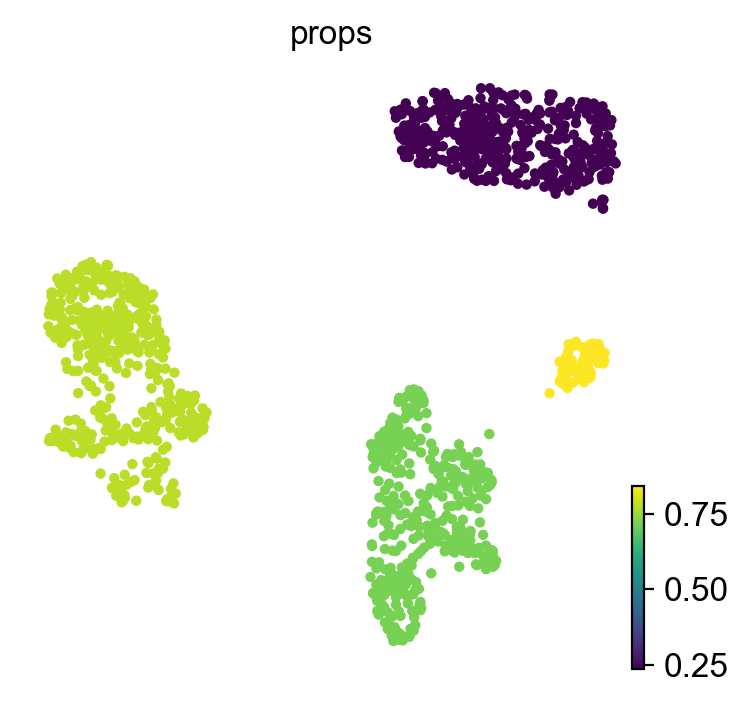

In [30]:
scv.pl.umap(adata,color="props",cmap="viridis")

In [31]:
tokeep=props[props>.05].index

In [32]:
import seaborn as sns
df=(adata_fitted[adata_fitted.obs.leiden.isin(tokeep)].obs["assignments_proj"]
 .groupby(adata_fitted[adata_fitted.obs.leiden.isin(tokeep)].obs["leiden"])
 .value_counts(normalize=True)
 .rename("proportion")
 .reset_index())

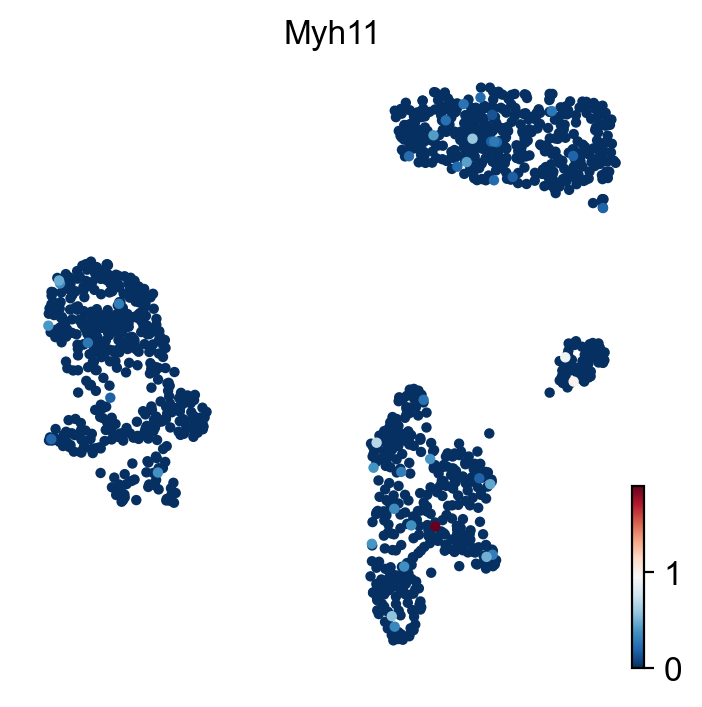

In [33]:
scv.pl.umap(adata,color="Myh11")

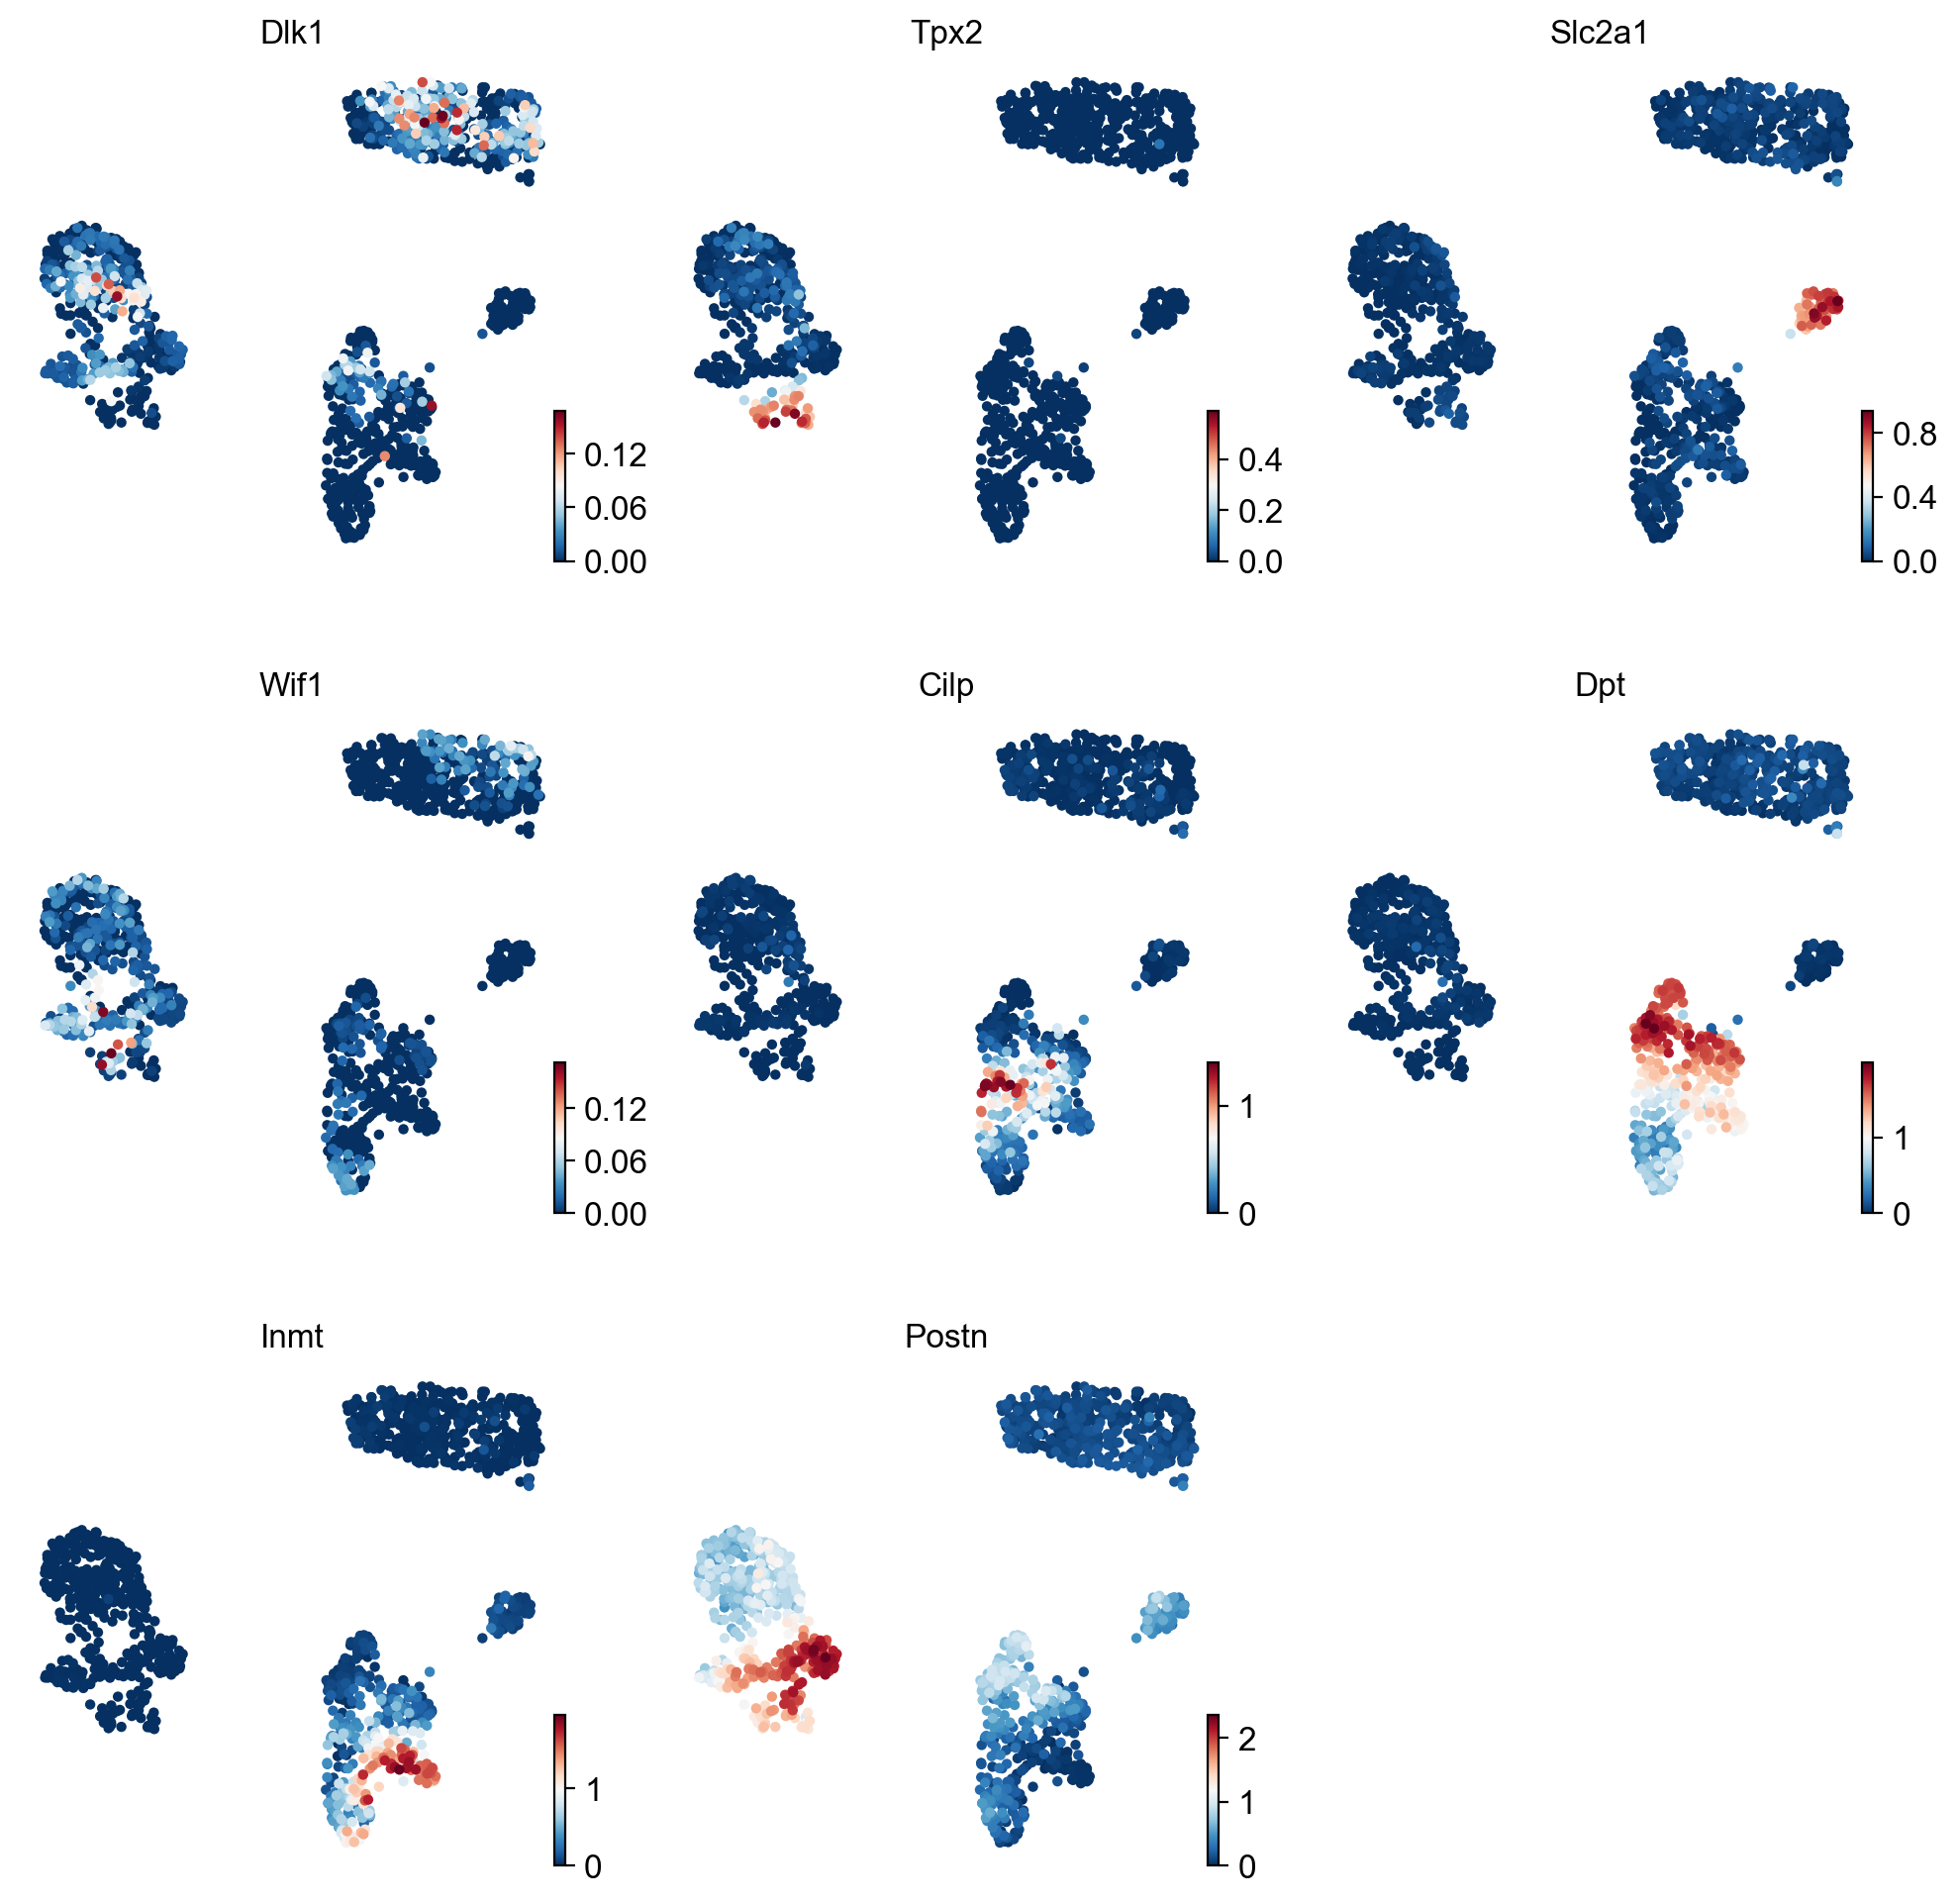

In [34]:
scv.pl.umap(adata,color=["Dlk1","Tpx2","Slc2a1","Wif1","Cilp","Dpt","Inmt","Postn"],ncols=3,smooth=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


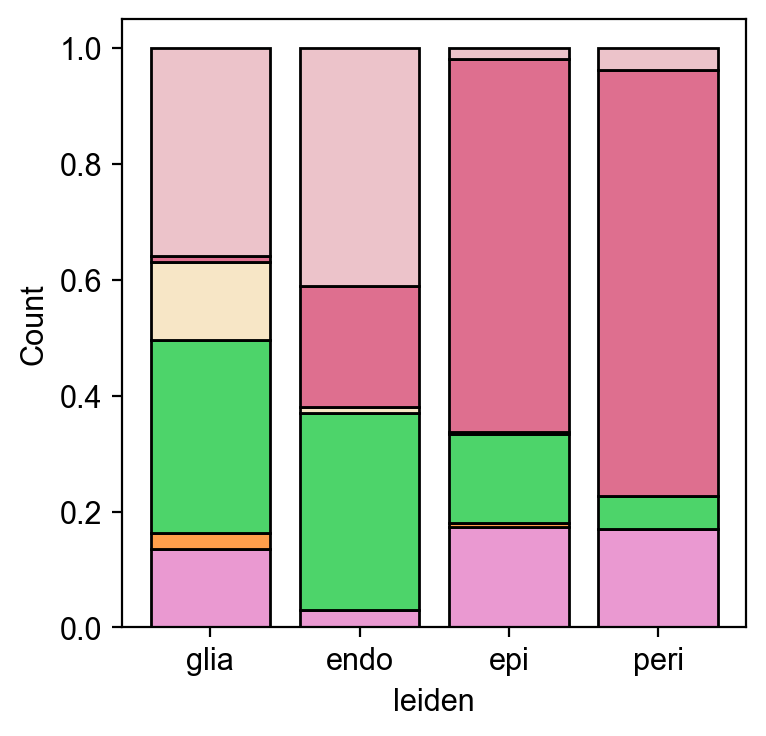

In [35]:
import matplotlib.pyplot as plt
ax=sns.histplot(df, x="leiden",hue="level_1",weights="proportion",multiple="stack",
                palette=sns.color_palette(ass_cols[df.level_1.cat.categories].values),shrink=0.8)
ax.legend(frameon=False)

In [36]:
adata_glia.write("adata_glia.h5ad")
adata.write("adata_carr.h5ad")

saving figure to file ./figures/scvelo_enFib_ours.pdf
saving figure to file ./figures/scvelo_enFib_carr.pdf


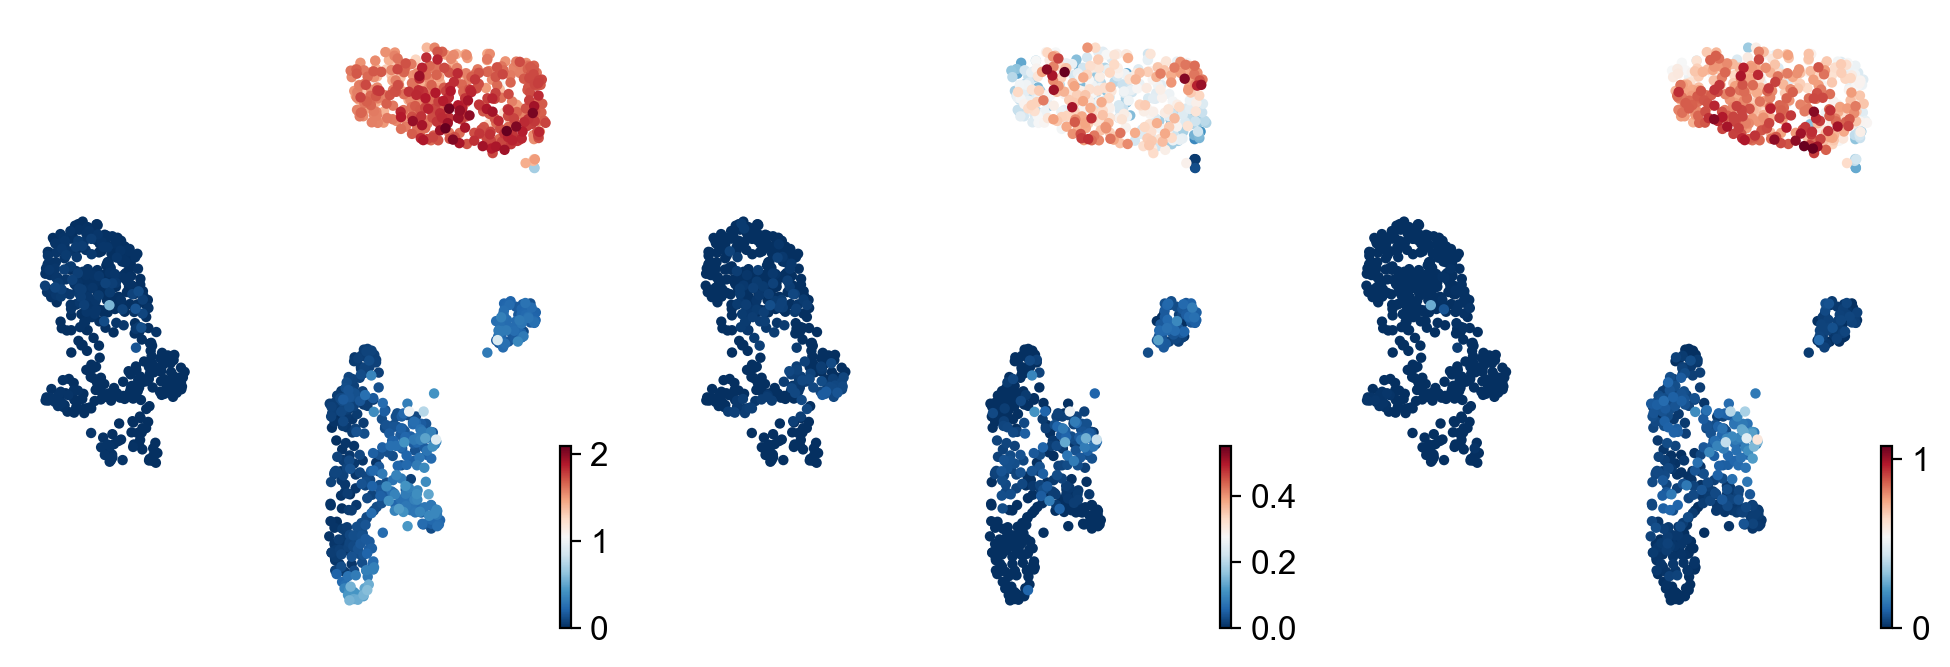

In [270]:
axs=scv.pl.umap(adata_glia,color=["Cp","Sox9","Enpp2"],ncols=4,smooth=True,show=False,save="enFib_ours.pdf")
for ax in axs:
    ax.set_title(ax.get_title(),style="italic",size=20)
    
scv.pl.umap(adata,color=["Cp","Sox9","Enpp2"],ncols=3,smooth=True,title="",save="enFib_carr.pdf")


saving figure to file ./figures/scvelo_enfib_carr_ours.pdf


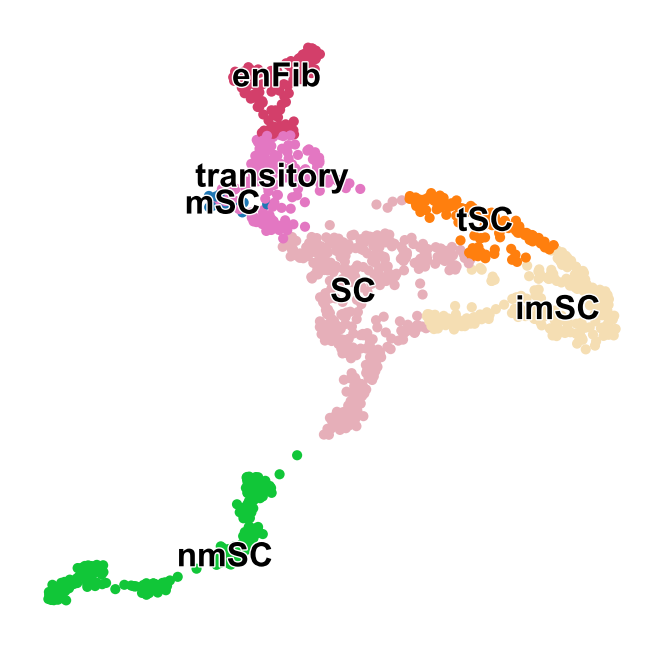

saving figure to file ./figures/scvelo_enfib_carr.pdf


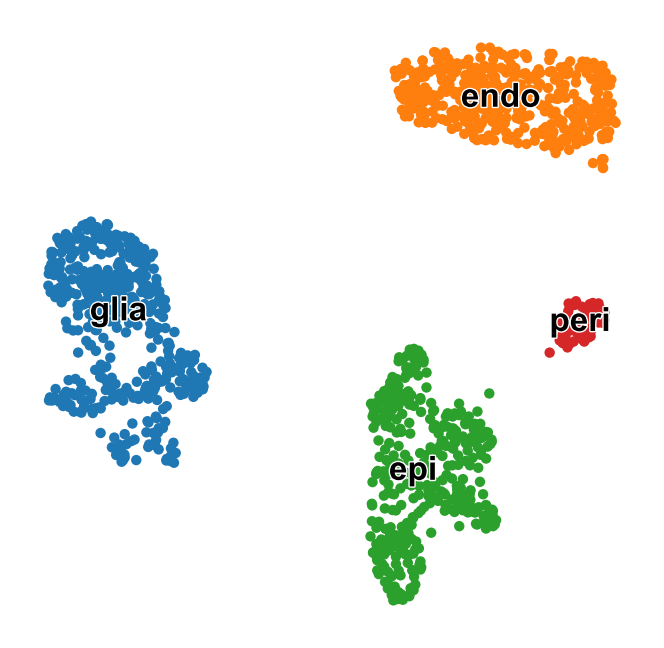

In [271]:
scv.pl.umap(adata_glia,color="milestones",title="",save="enfib_carr_ours.pdf")
scv.pl.umap(adata,color="leiden",legend_loc="on data",title="",save="enfib_carr.pdf")

In [247]:
adata_mes=adata[adata.obs.leiden!="glia"]

In [248]:
sc.tl.rank_genes_groups(adata_mes,"leiden")

Trying to set attribute `.uns` of view, copying.


In [249]:
epi=sc.get.rank_genes_groups_df(adata_mes,"epi").names[:25].values

peri=sc.get.rank_genes_groups_df(adata_mes,"peri").names[:25].values

endo=sc.get.rank_genes_groups_df(adata_mes,"endo").names[:25].values

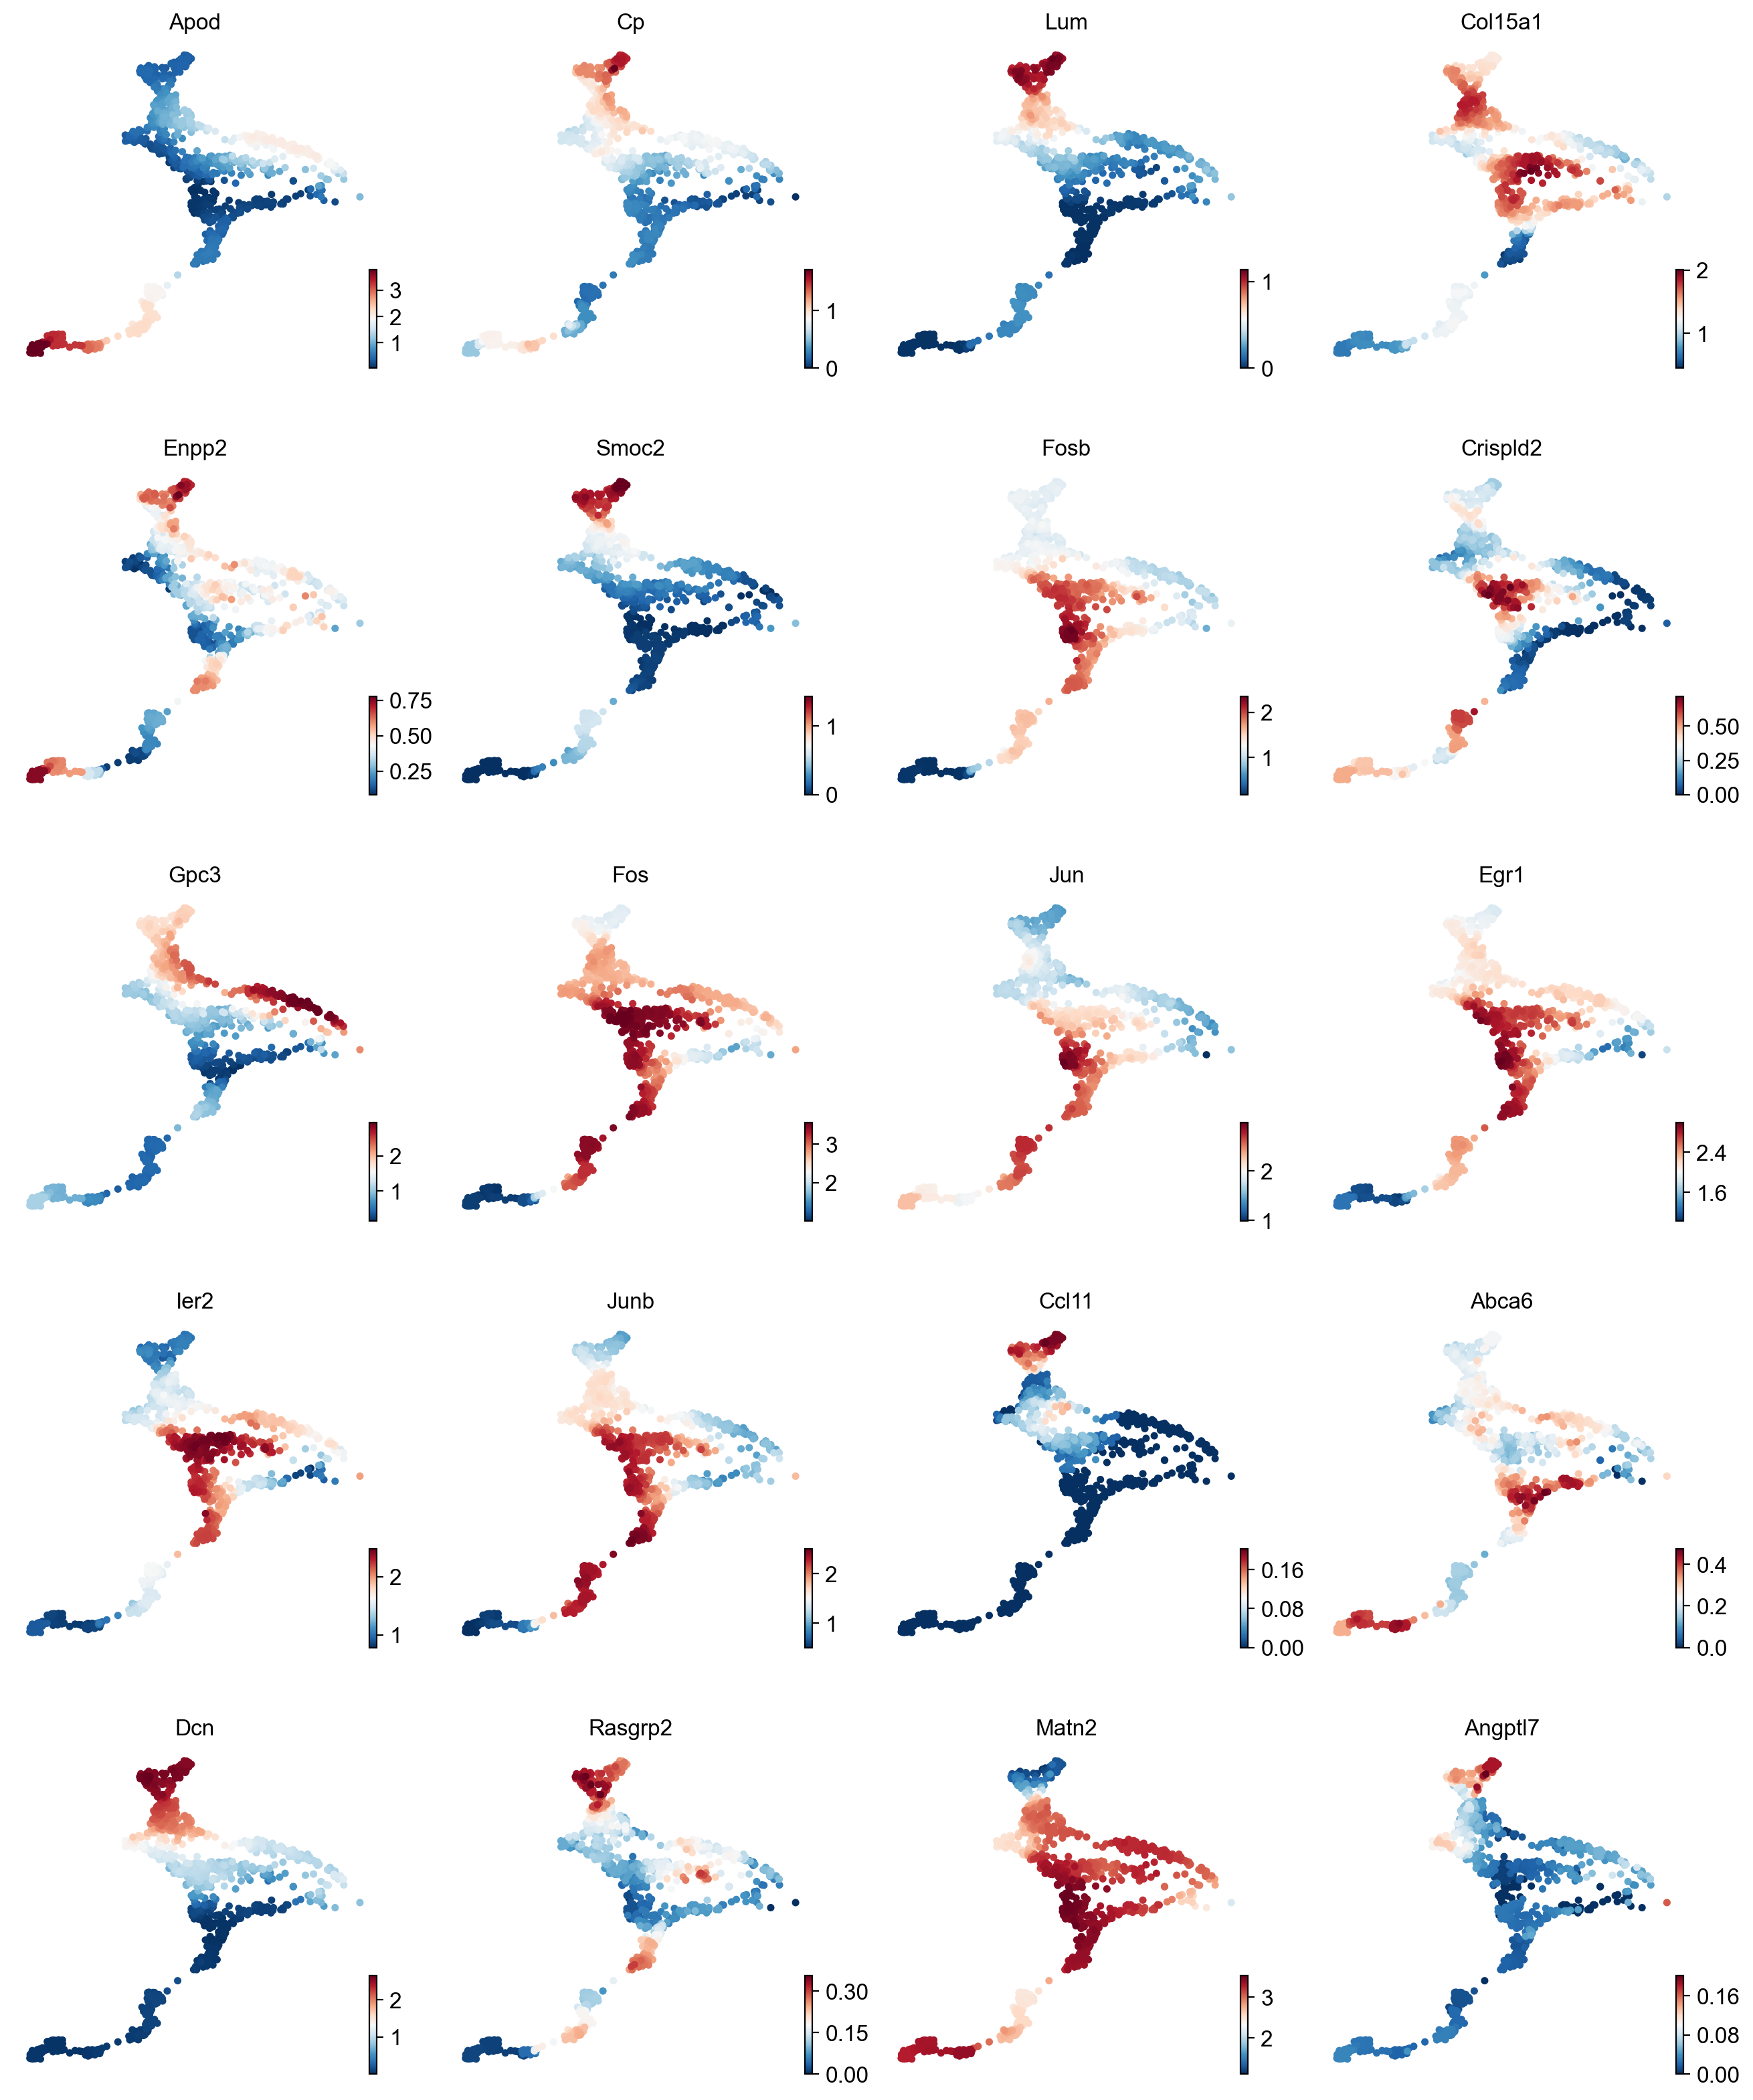

In [197]:
scv.pl.umap(adata_glia,color=endo[:20].tolist(),ncols=4,smooth=True)

In [189]:
sc.get.rank_genes_groups_df(adata_mes,"endo").set_index("names").loc["Sox9"]

scores            1.392281e+01
logfoldchanges    4.202887e+00
pvals             5.032264e-36
pvals_adj         1.139849e-33
Name: Sox9, dtype: float64

In [182]:
sc.tl.score_genes(adata_glia,epi,score_name="epi score")
sc.tl.score_genes(adata_glia,peri,score_name="peri score")
sc.tl.score_genes(adata_glia,endo,score_name="endo score")

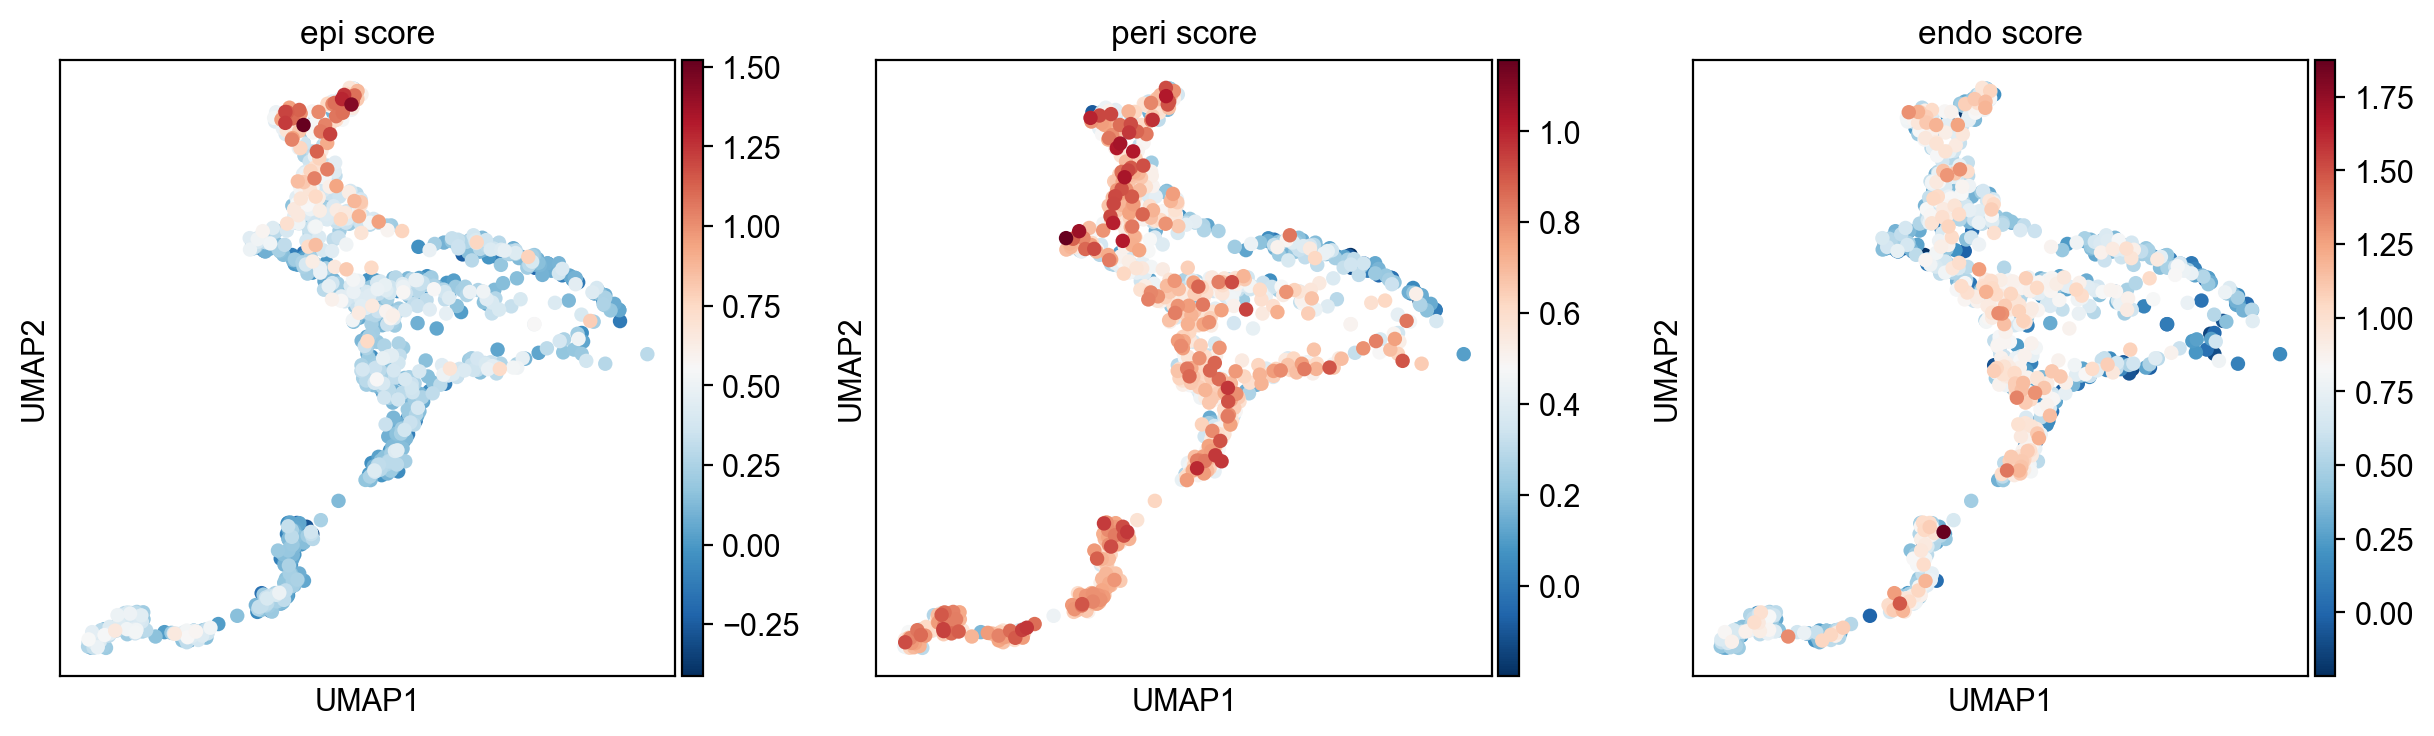

In [183]:
sc.pl.umap(adata_glia,color=["epi score","peri score","endo score"])

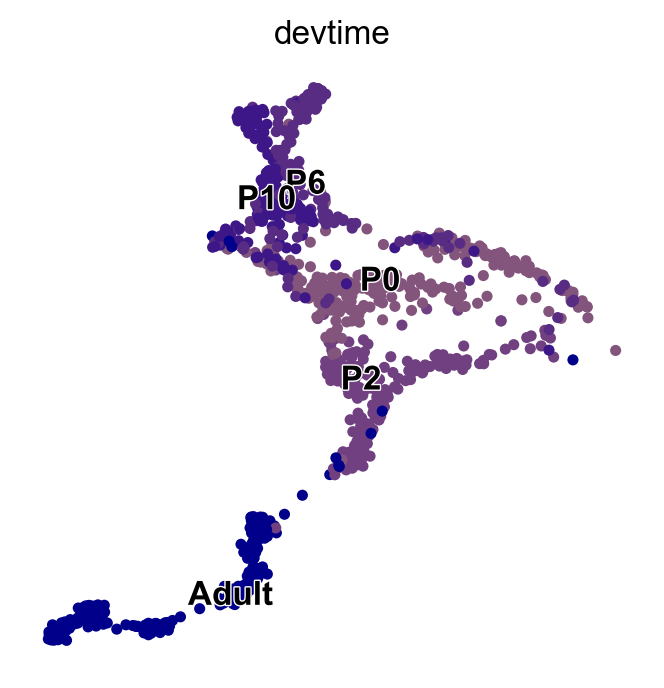

In [184]:
scv.pl.umap(adata_glia,color=["devtime"],smooth=True)

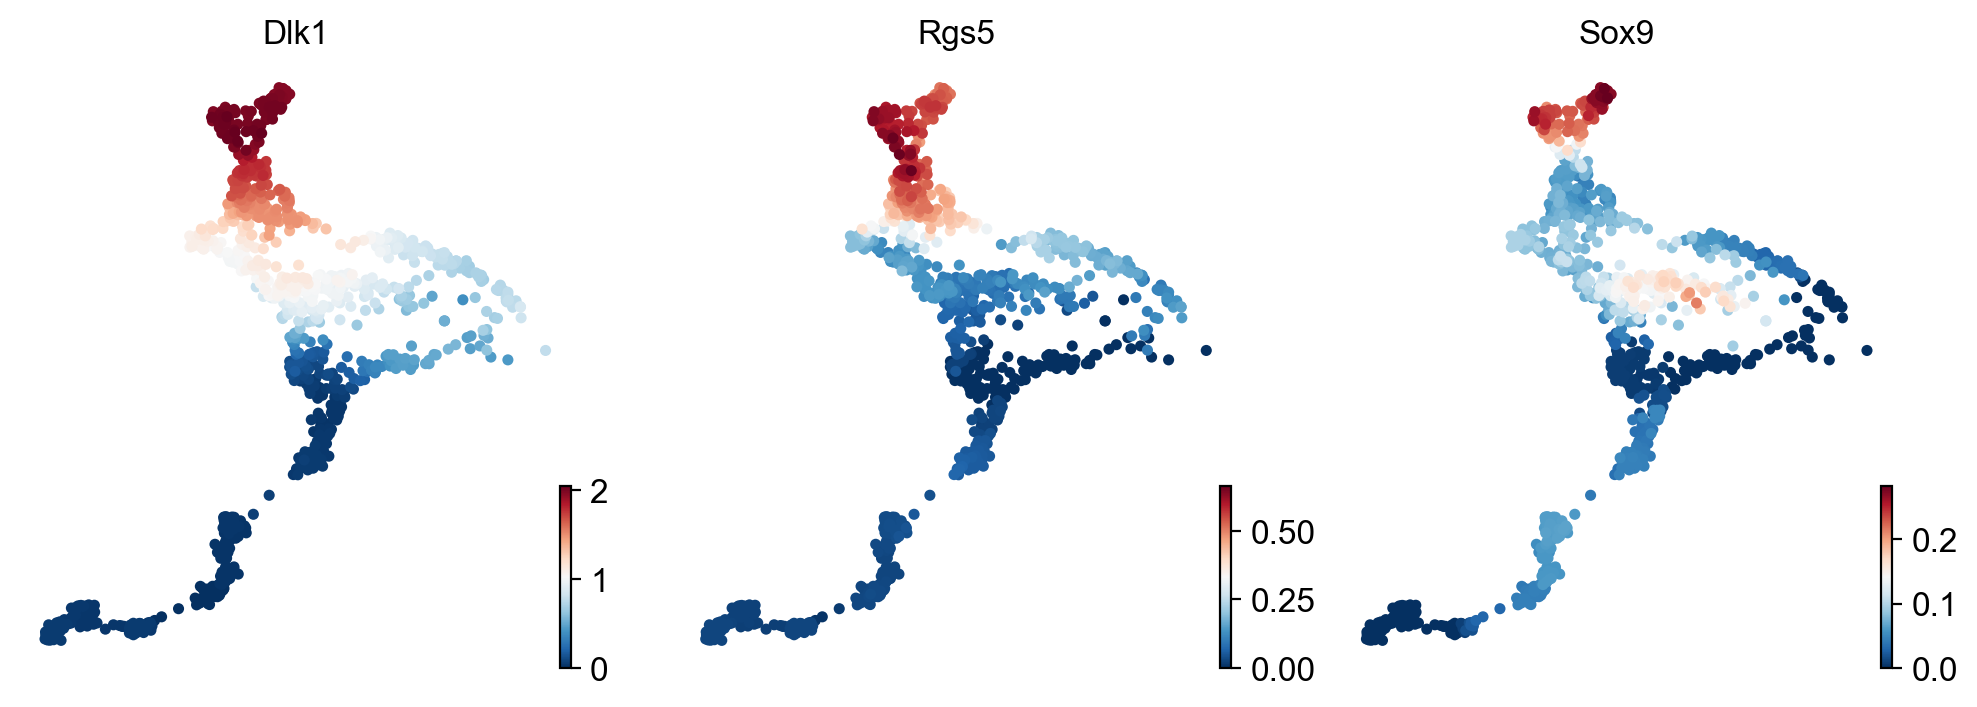

In [185]:
scv.pl.umap(adata_glia,color=["Dlk1","Rgs5","Sox9"],smooth=True)

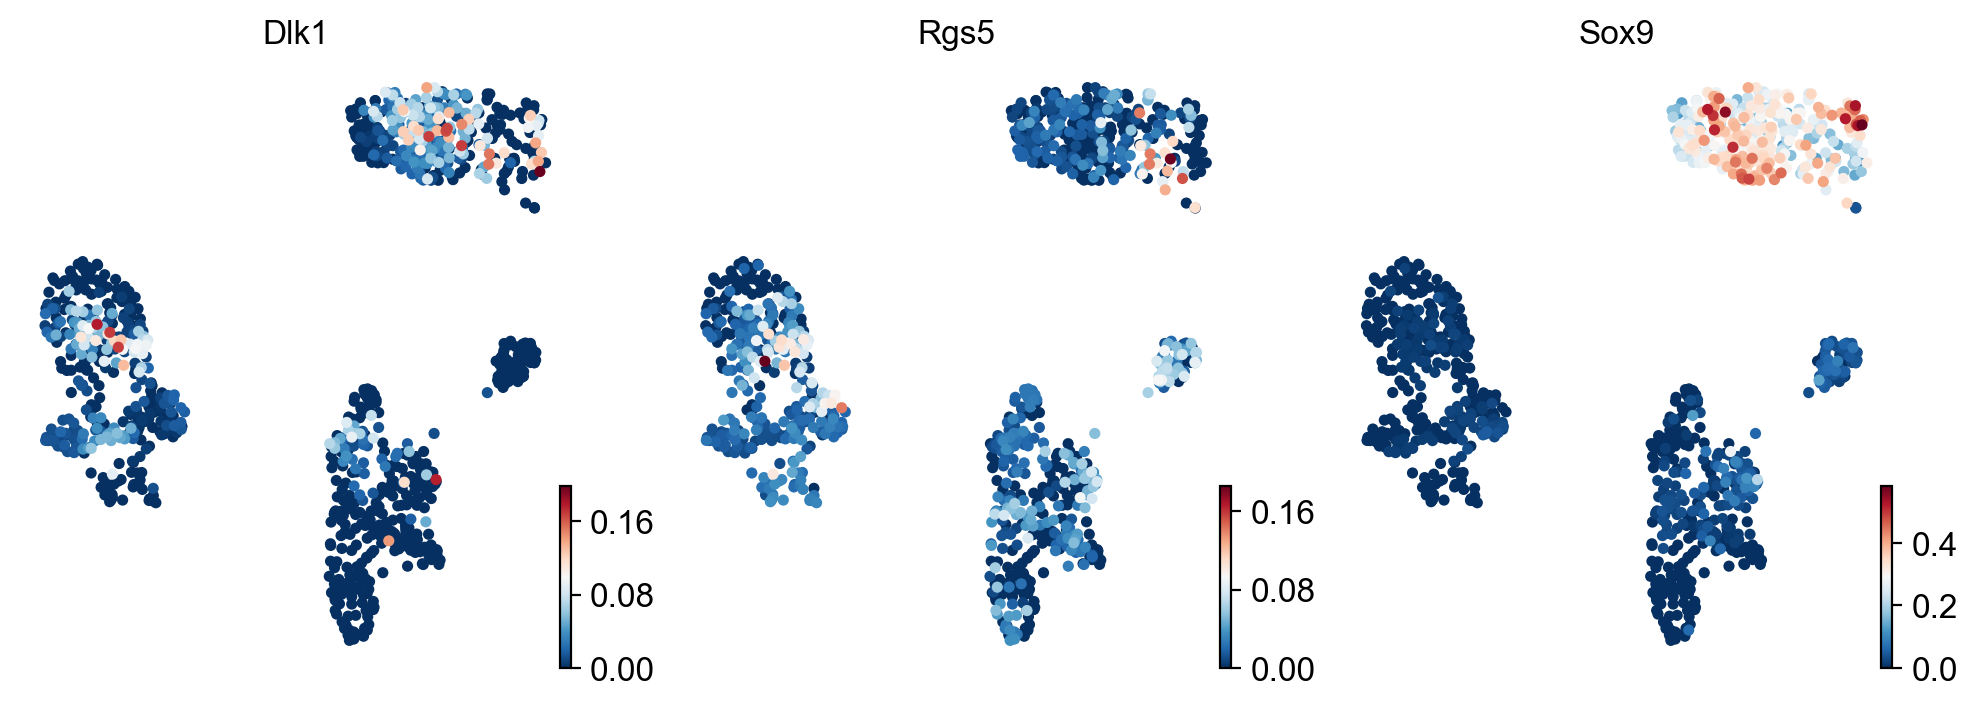

In [190]:
scv.pl.umap(adata,color=["Dlk1","Rgs5","Sox9"],ncols=3,smooth=True)

In [ ]:
adata.obs.assignments_proj[adata.obs.leiden=="7"].value_counts()

In [ ]:
adata.write("adata_projected.h5ad")